# Preface

Hello and welcome. The following notebook is a supplement to our write up, found [HERE]. In this jupyter notebook, for the sake of replicability, we provide the code for our computations and include a few more graphics.  

## Install Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
import re
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import bootstrap
from functools import reduce
import plotly.express as px

# This line tells iPython to not display warnings.
import warnings
warnings.filterwarnings('ignore')
#
# Style of plots
#plt.style.use('seaborn-colorblind')
plt.style.use('dark_background')

#import statsmodels.api as sm 
#import matplotlib.dates as mdates

## Define Functions

In [7]:
def get_datetime(timestamp):
    '''Create A datatme object in the format %m/%d/%Y'''
    return datetime.strptime(timestamp, '%m/%d/%Y')

def read_data_clean(department):
    '''Read in data from LAPD and NYPD. Here it is possible to add the csv for other datasets.'''
    police_department = {'LAPD':'Arrest_Data_from_2010_to_2019.csv','NYPD':'NYPD_Arrests_Data__Historic_.csv'}
    df = pd.read_csv(police_department[department])
    
    # Cleaning data
    if department == 'NYPD':
        
         # Full data frame
        df = df[['ARREST_DATE','OFNS_DESC','PERP_RACE']]
        df.rename(columns = {'ARREST_DATE':'Arrest Date','OFNS_DESC':'Charge Group Description','PERP_RACE':'Descent Code'}, inplace = True)
        
        # restrict the races we examine so that we have a full dataset
        df = df[~df['Descent Code'].isin(['AMERICAN INDIAN/ALASKAN NATIVE', 'UNKNOWN'])]
        
        # Income and Poverty Residual Data from R code:
        income_url = 'NYPD_income_mean_pearson_residuals_R.csv'   #'Income_nypd_chi_all.csv'
        poverty_url = 'NYPD_poverty_mean_pearson_residuals_R.csv'    #'poverty_nypd_chi_all.csv'
    elif department == 'LAPD':
        df = df[df['Descent Code'].isin(['W','B','H'])]
        
        # restrict the races we examine so that we have a full dataset
        df['Descent Code'].replace(to_replace = ['B', 'H',  'W'],
                                value = ['Black','Hispanic/Latin/Mexican', 'White'],
                                inplace = True)
        
        # Income and Poverty Residual Data from R code:
        income_url =   'LAPD_income_mean_pearson_residuals_R.csv'#'income_res_all_years.csv'
        poverty_url =  'LAPD_poverty_mean_pearson_residuals_R.csv'   #'poverty_res_all_years.csv'
        
    # Pearson Residuals of Income Data Frame
    df_income = pd.read_csv(income_url)
    df_income.columns = ['Charge Group Description', 'Low Income','Mid-Low Income','Mid-High Income','High Income', 'Year']
    df_income['Charge Group Description'] = df_income['Charge Group Description'].apply(lambda x: re.sub("\d+", "", x))
    # Pearson Residuals of Poverty Percentage Data Frame
    df_poverty = pd.read_csv(poverty_url)
    df_poverty.columns = ['Charge Group Description', 'Low Poverty', 'Mid-Low Poverty', 'Mid-High Poverty', ' High Poverty', 'Year']
    df_poverty['Charge Group Description'] = df_poverty['Charge Group Description'].apply(lambda x: re.sub("\d+", "", x))  

    # Create Datetime column using the function from above
    df['DateTime'] = df['Arrest Date'].apply(lambda x: get_datetime(x))
    
    # Create a column of the year that the arrest took place using the datetime column
    df['Year'] = df['DateTime'].apply(lambda x: x.year)
    
    # Assigning a single value to an arrest so that we can apply metrics to the number of arrests
    df['Counts'] = 1
    return df, df_income, df_poverty

def pearson_chi2_year(df_race,year, return_obs_exp = False):
    '''Perform a Chi2 test on police data. Built for Race compared to CGD.'''
    # Empty data frame containing all unique CGD to merge data onto
    df_empty_charges = pd.DataFrame(df_race['Charge Group Description'].unique().tolist(), columns = ['Charge Group Description'])  
    
    # Filter by year
    df_year = df_race[df_race['Year'] == year]
    
    # Sample 10,000 arrested individuals with replacement out of the year
    df_sample = df_year.sample(n = 10000, replace = True)
    
    # create a contingency table using pd.crosstab()
    df_contingent = pd.crosstab(df_sample['Descent Code'],
                            df_sample['Charge Group Description'], 
                               margins = False)
    
    # We want a full contingency table, so we drop those columns where there are fewer than 10.
    df_contingent = df_contingent[df_contingent > 10].dropna(axis = 1) # keeps any col with all values greater than 10
    
    # Pearson's Chi Square Test
    test_stat, p_val, dof, expected = chi2_contingency(df_contingent)
    if return_obs_exp:
        return df_contingent, pd.DataFrame(expected,df_contingent.index.tolist(), df_contingent.columns.tolist())
    else:
        prob = 0.95
        critical = chi2.ppf(prob, dof)
        if p_val < .05:
            print('Year %s: P-value= %f, Test Statistic= %f, dof = %f, critical value = %f'%(year,p_val,test_stat, dof, critical))
            print('Reject H0 (DEPENDENT)')
        else:
            print('Year %s: P-value= %f, Test Statistic= %f, dof = %f, critical value = %f'%(year,p_val,test_stat, dof, critical))
            print('Fail to Reject H0')
            
def mean_pearson_residuals_year(year, df_race, k = 15):
    '''Calculates the mean pearson residuals out of k trials.'''
    # Empty Dataframe of all CGD which we add residuals residuals on
    df_empty_charges = pd.DataFrame(df_race['Charge Group Description'].unique().tolist(), columns = ['Charge Group Description'])  
    
    # Empty list to hold the DataFrames of residuals from each trial
    residuals = []
    for i in range(k):
            # Call function above to return DataFrame of observed data and expected data from sample
            df_observed, df_expected = pearson_chi2_year(df_race, year = year, return_obs_exp = True)
            
            # for each cell (O-E)/ sqrt(E). Take transpose so that race becomes Columns and CGD becomes Index
            df_residuals = pd.merge(df_empty_charges,
                                    ((df_observed - df_expected)/np.sqrt(df_expected)).T,
                                    how = 'outer',
                                    left_on = 'Charge Group Description',
                                    right_index = True)
            residuals.append(df_residuals)
    df_mean = pd.DataFrame(df_race['Charge Group Description'].unique().tolist(), columns = ['Charge Group Description'])
    races = residuals[0].set_index('Charge Group Description').columns.tolist()
    df_mean[races] = 0
    for i in range(len(residuals)):
        df_mean[races] = df_mean[races] + residuals[i][races]
    df_mean[races] = df_mean[races]/k
    df_mean.set_index('Charge Group Description', inplace = True)
    return df_mean

def get_res_race(race):
    '''Formats a dataframe of residuals of Race and CGD so that we can plot the results in a timeseries.'''
    df_res_charge = pd.DataFrame(residuals_year[0].index)
    for frame in residuals_year:
        df_res_charge = pd.merge(df_res_charge,frame[race], how = 'outer', left_on = 'Charge Group Description', right_index = True)
    df_res_charge = df_res_charge.set_index('Charge Group Description').T 
    df_res_charge.index = years = np.sort(np.array(df_race['Year'].unique())) # what years are present in our dataset
    return df_res_charge

def get_res_income(income, df_income):
    '''Formats a dataframe of residuals of Income and CGD. Data comes from code in R.'''
    years = np.sort(np.array(df_income['Year'].unique()))
    df_res_income = pd.DataFrame(df_income['Charge Group Description'].unique().tolist(), columns = ['Charge Group Description'])
    for year in years:
        df_res_income = pd.merge(df_res_income,
                     df_income[df_income['Year'] == year][['Charge Group Description',income]].set_index('Charge Group Description'),
                     how = 'outer', left_on = 'Charge Group Description', right_index = True)
    df_res_income.set_index('Charge Group Description', inplace = True)
    df_res_income.columns = years
    df_res_income = df_res_income.T
    return df_res_income

def get_res_poverty(poverty, df_poverty):
    '''Formats a dataframe of residuals of poverty and CGD. Data comes from code in R.'''
    years = np.sort(np.array(df_poverty['Year'].unique()))
    df_res_poverty = pd.DataFrame(df_poverty['Charge Group Description'].unique().tolist(), columns = ['Charge Group Description'])
    for year in years:
        df_res_poverty = pd.merge(df_res_poverty,
                     df_poverty[df_poverty['Year'] == year][['Charge Group Description',poverty]].set_index('Charge Group Description'),
                     how = 'outer', left_on = 'Charge Group Description', right_index = True)
    df_res_poverty.set_index('Charge Group Description', inplace = True)
    df_res_poverty.columns = range(2010,2020)
    df_res_poverty = df_res_poverty.T
    return df_res_poverty

## Read/Clean Data

In [8]:
department = 'LAPD'
df_race, df_income, df_poverty = read_data_clean(department = department)

## Number of Arrests for Each Race broken down by Charge Group Description

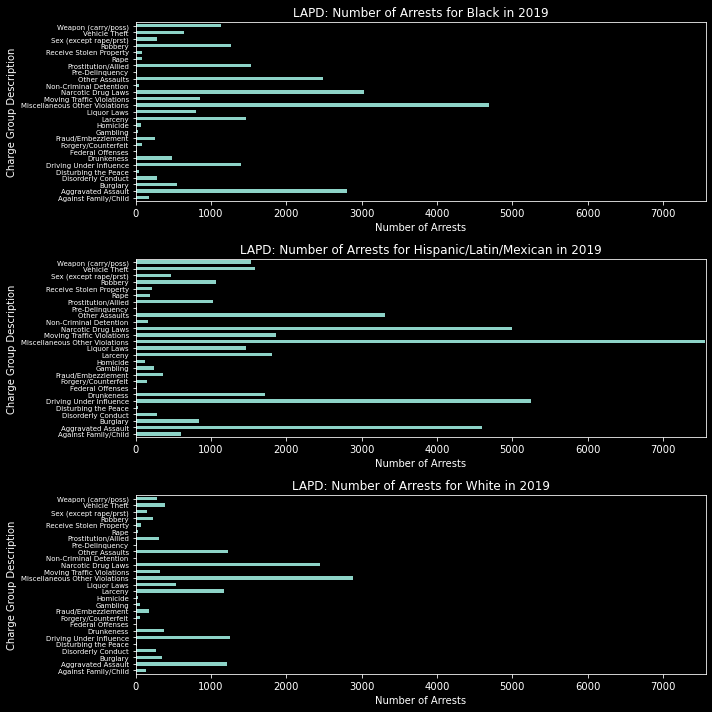

In [64]:
year = 2019
df_year = df_race[df_race['Year'] == year]
df_crosstab = pd.crosstab(df_year['Descent Code'],
                            df_year['Charge Group Description'], 
                               margins = False)
races = df_crosstab.index.tolist() # what races are present in our dataset
fig, axis  = plt.subplots(nrows = len(races), ncols = 1, figsize = (10,10))
max_val = df_crosstab.max().max() # maximum value in our dataset. Used for x_lim
for i,race in enumerate(races):
    df_crosstab.loc[race].plot(kind = 'barh',ax = axis[i], xlim = (0,max_val + 10))
    axis[i].set(title = '%s: Number of Arrests for %s in %s'%(department,race,year), xlabel = 'Number of Arrests')
    axis[i].tick_params(axis='y', labelsize=7)
fig.tight_layout()


These graphs show the total number of arrests for a charge group. From these graphs it is not clear which, if any, charge group descriptions have more counts than we would expect within the context of the data. For example, are there more arrests for Miscellaneous Other Violations of individuals with Hipanic/Latin/Mexican descent than expected? First, we must establish if there is an association between racial group and charge group description. To do this, we can use Pearson's Chi-Square test, letting the null hypothesis be that racial group and charge group description are independent. Indepence would mean that an arrested individuals race does not affect the charge group description that they were arrested for. First we will analyze arrests that occured in 2019.

## Pearson's Chi-Square Test

In [65]:
pearson_chi2_year(df_race,year = 2019)

Year 2019: P-value= 0.000000, Test Statistic= 474.239317, dof = 34.000000, critical value = 48.602367
Reject H0 (DEPENDENT)


Now that we have concluded that racial group and charge group descritpion are related from the arrest data from LAPD in 2019, we want to determine which racial group and charge group description combination are contributing the most to dependancy. Since the chi2 test statistic is calculated by summing the squares of the difference between observed frequency and expected frequency over the expected frequency, sum((O-E)^2/E), if we compare the residuals of each cells observed frequency and the cells expected frequency we can determine which combination contributes the most and the least. A more approprate comparison is calculating the Pearson residuals between cells, (O-E)/ sqrt(E), which standardizes the residuals so that they have a mean of 0 and a standard deviation of 1. Therefore, any Pearson Residual over 2 or under -2 are major contributers to dependency. We will compute the Pearson Residuals with samples of 10,000 individuals with replacement from our arrest data and do this k times so that we can find a mean value of the Pearson Residuals.

## Mean of Pearson Residuals

### Race

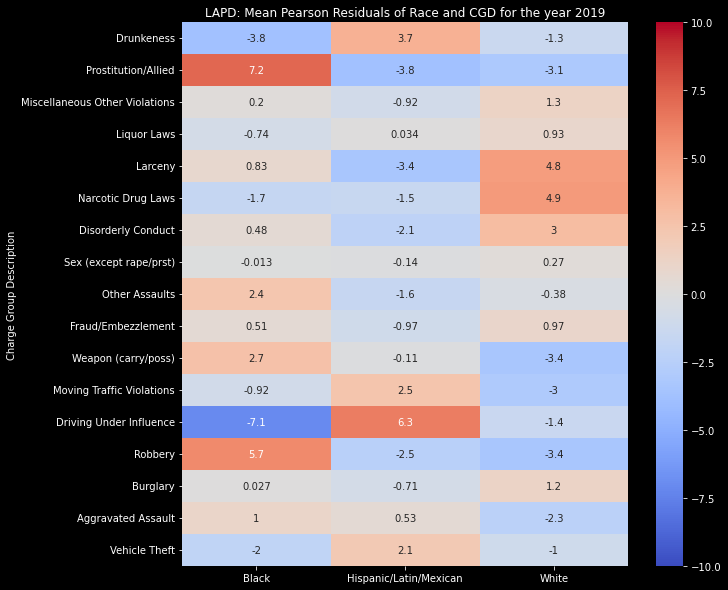

In [66]:
fig, ax = plt.subplots(figsize = (10,10))
year = 2019
text = sns.heatmap(mean_pearson_residuals_year(year, df_race).dropna(how = 'all'), annot=True, vmin = -10, vmax = 10,cmap = 'coolwarm' , ax = ax) 
text = ax.set(title = '%s: Mean Pearson Residuals of Race and CGD for the year %s'%(department,year))

Note that anything outside +2 or -2 is considered a major contributor. For Black, the largest contributors for dependency are Prostituion/Allied, Driving under Influence, and Robbery. For Hispanic/Latin/Mexican, the largest contributors for dependency are Driving Under Influence, Drunkenness, and Prostituion/Allied. For White, the largest contributors for dependency are Narcotic Drug Laws, Larceny and Weapon (carry/poss). 

### Income

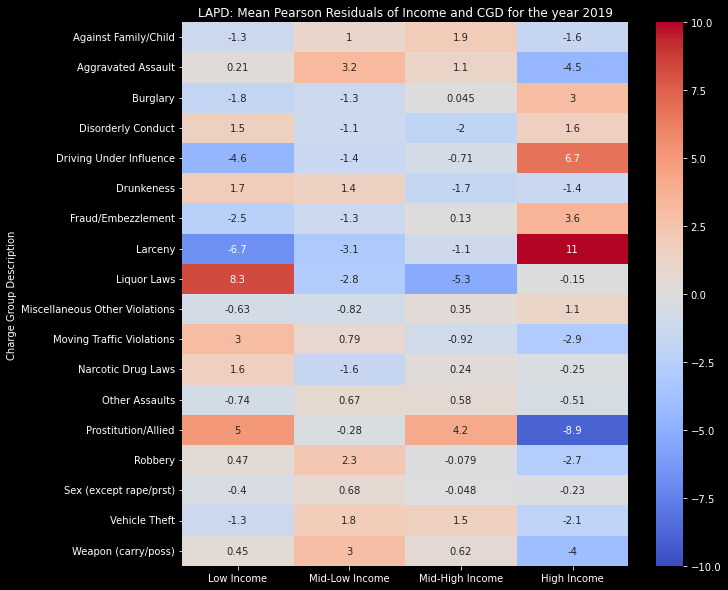

In [67]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_income[df_income['Year'] == 2019].drop('Year', axis = 1).set_index('Charge Group Description'),
           annot = True, vmin = -10, vmax = 10, cmap = 'coolwarm')
text = ax.set(title = '%s: Mean Pearson Residuals of Income and CGD for the year %s'%(department,year))

### Poverty

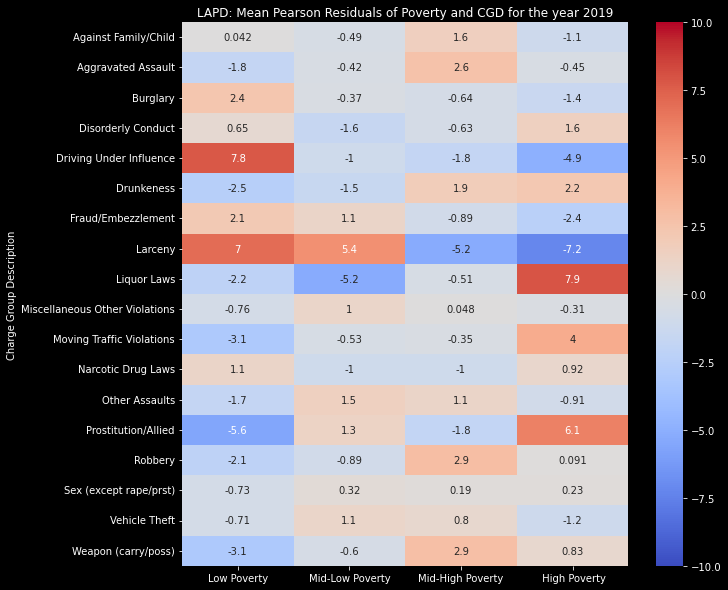

In [68]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_poverty[df_poverty['Year'] == 2019].drop('Year', axis = 1).set_index('Charge Group Description'),
           annot = True, vmin = -10, vmax = 10, cmap = 'coolwarm')
text = ax.set(title = '%s: Mean Pearson Residuals of Poverty and CGD for the year %s'%(department,year))

This heatmap visualizes the Mean of several Pearson Residuals from 2019 from the LAPD data. Note that we chose to set the vmin and vmax to -10 and 10 so that the most drasticically dependent combinations of charge group description and race are the most visible. We could also set the vmin and vmax to -2 and 2 so that the heatmap shows all of the major contributors to dependency. At this point it is important to understand how we calculate what a cells 'excpeted' value should be. Using the observed data in the contingency table, we sum the values in each row, which is called the marginal of the row or the row total, and we do the same for the column. Then, to get the expected value of a cell, we multiply the row total that the cell is in by the column total of where the cell is and we divide by the total number of data points called the grand total, E = (Row Total * Colum Total)/ (Grand Total). This is important to know because it explains that our comparision of a charge group description and a race is relative to the total arrests of race and to the total arrests for a charge group description. In other words, Gambling arrests of Black individuals is compared to the total number of arrests for Black individuals and to the total number of gambling arrests. 

## Vizualizing the Change of Pearson Residuals over Time

In [70]:
# Mean Pearson Residuals of every year in the dataset
years = np.sort(np.array(df_race['Year'].unique())) # what years are present in our dataset
residuals_year = []
for year in years:
    residuals_year.append(mean_pearson_residuals_year(year, df_race))

### Race

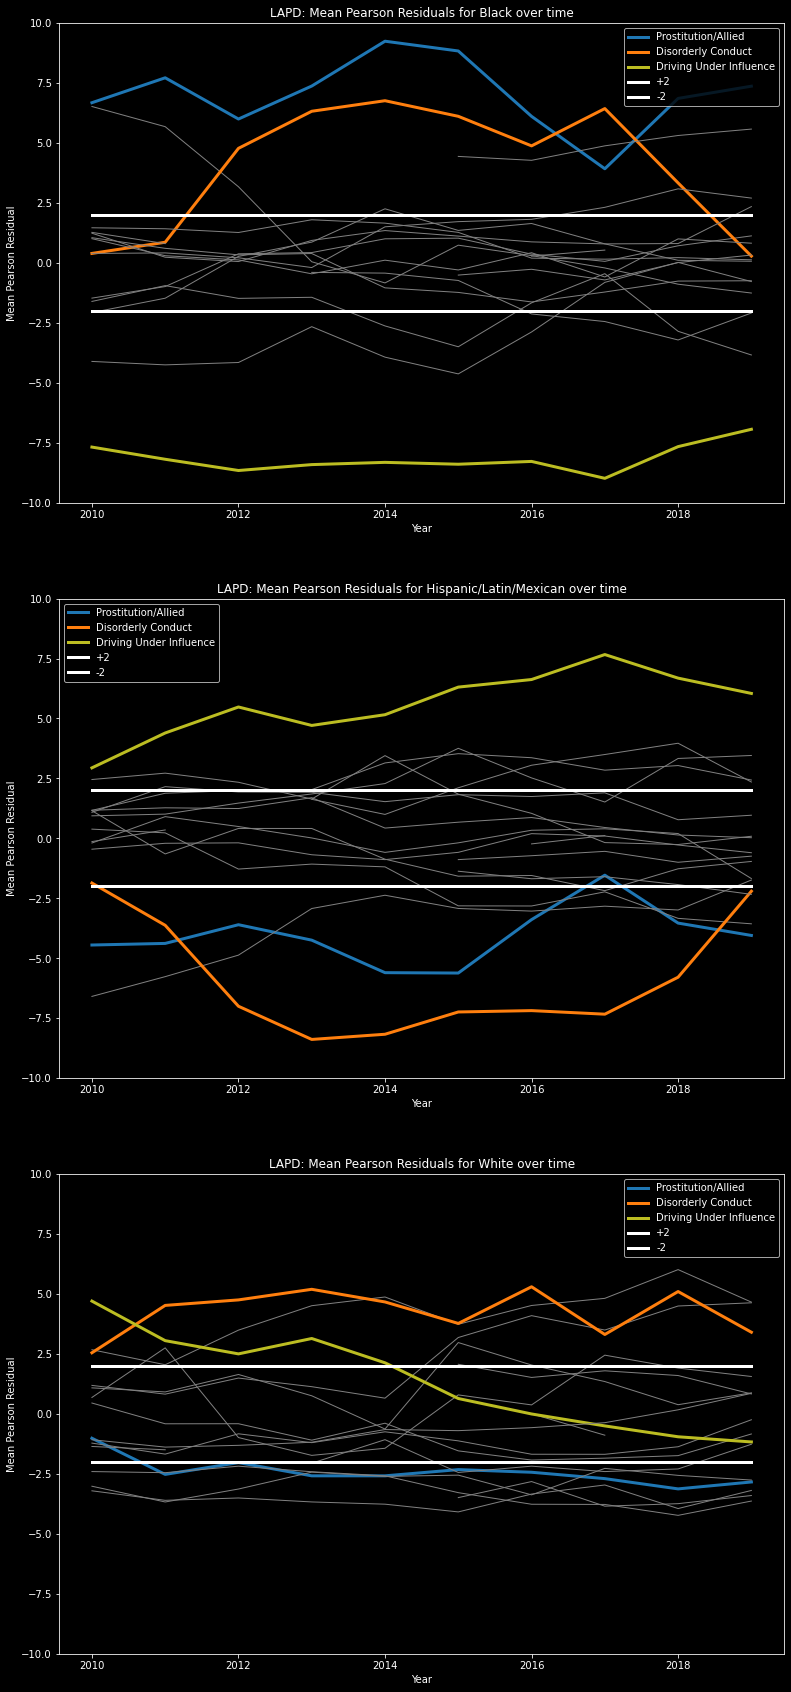

In [78]:
## Highlight CGD of particluar note in LAPD
## Matplotlib of Mean Pearson Residuals change over time for every Race
notable_cols =  ['Driving Under Influence','Prostitution/Allied',
                  'Disorderly Conduct',
                '+2', '-2'] # By inspection
colors = ['tab:blue','tab:orange','tab:olive','white','white']
races = residuals_year[0].columns
fig, axis = plt.subplots(nrows = len(races), ncols = 1, figsize = (13,len(races) * 10))
for i, race in enumerate(races):
    df_p_res = get_res_race(race)
    df_p_res['+2'] = 2
    df_p_res['-2'] = -2
    color_num = 0
    for col in df_p_res.columns:
        if col in notable_cols:  
            axis[i].plot(df_p_res.index,df_p_res[col], linewidth = '3', color = colors[color_num], label = col)
            #axis[i].text(df_p_res.index[-1] + .5,df_p_res[col].tolist()[-1],col, fontsize = 14)
            color_num +=1
        else:
            axis[i].plot(df_p_res.index,df_p_res[col], color = 'grey', linewidth = '1')
    text = axis[i].set(ylim = (-10.00, 10.00),
                xlabel = 'Year',
                ylabel ='Mean Pearson Residual',
                title = '%s: Mean Pearson Residuals for %s over time'%(department,race))
    axis[i].legend()
    

The changes in Mean Pearson Residuals over time deomstrates that the driving factors of dependency changes from year to year. Visualizing the changes over time helps spot some highly dependent CGD that would have slipped unseen from a single year of a mean pearson residual. For example, Black individuals arrested for Disordely Conduct was not one of the largest values in the heatmaps from 2019. Our heatmap indicated that in 2019 the mean pearson residual of Black individuals arrested for Disordely Conduct the  was .48, a weak contributor, but the changes over time plot illustrates that in previous years this combination is  indeed a major contributor for those years dependency.

### Income Level

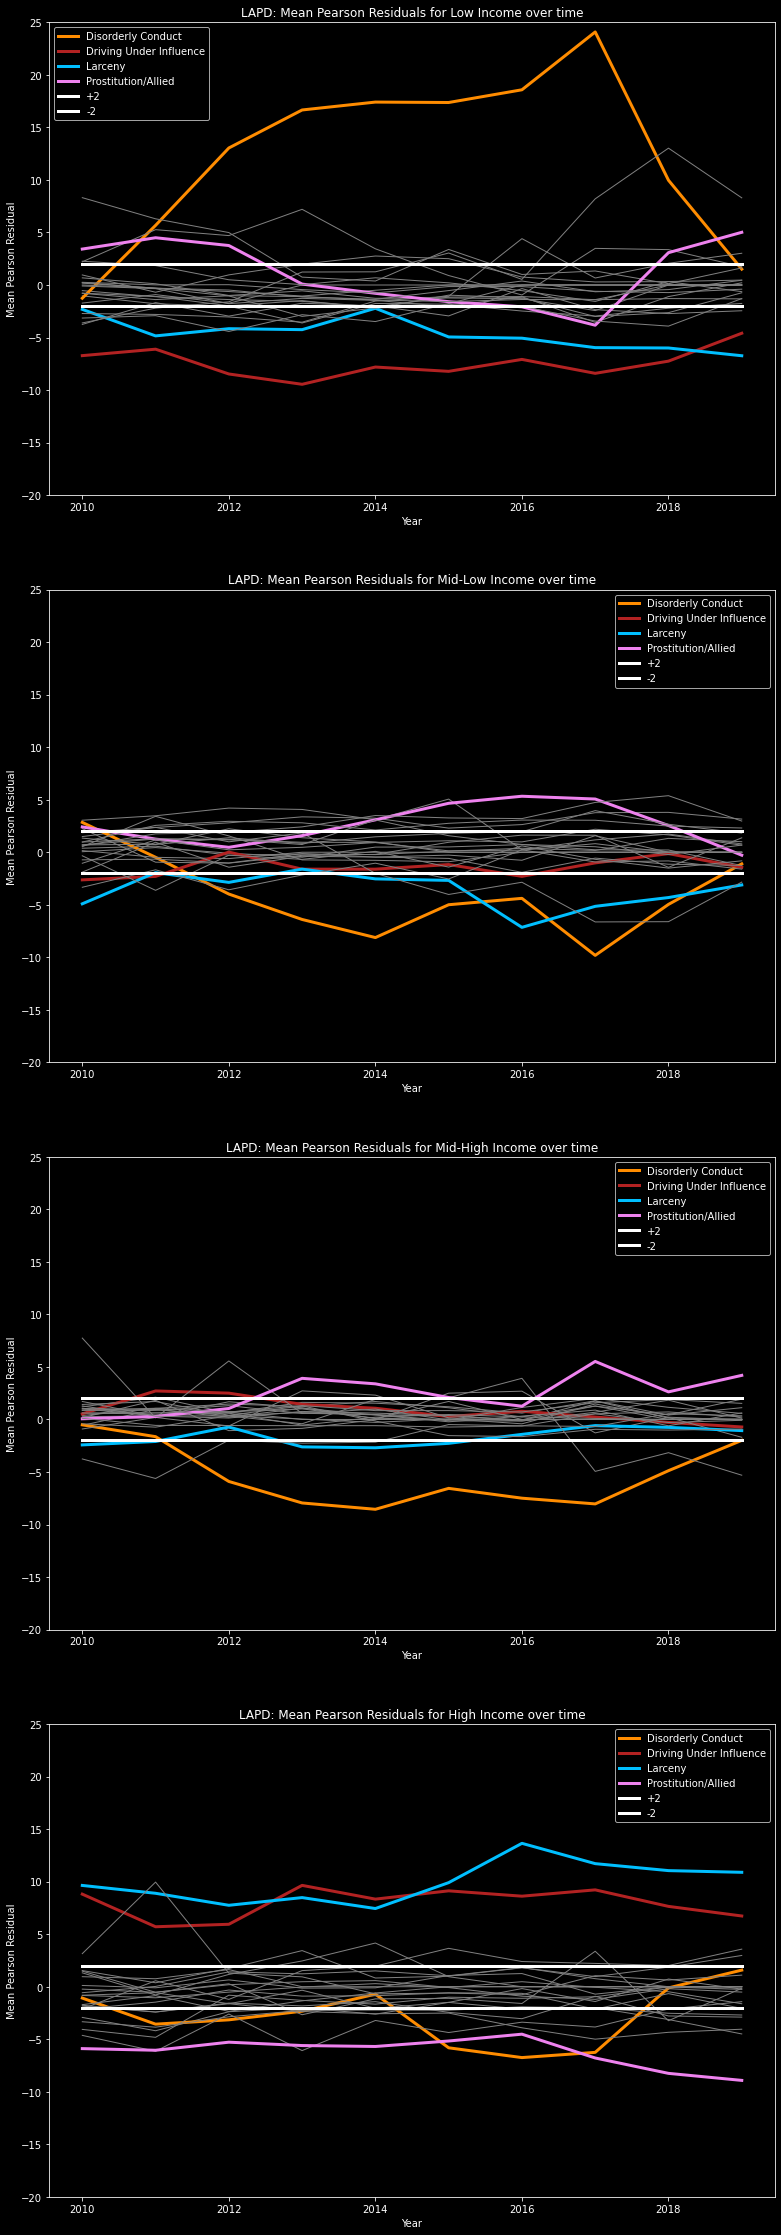

In [82]:
notable_cols =  ['Larceny','Driving Under Influence', 'Prostitution/Allied', 'Disorderly Conduct', '+2','-2']

# NYPD cols: ['PETIT LARCENY', 'DISORDERLY CONDUCT', 'DANGEROUS DRUGS','GRAND LARCENY', '+2','-2'] # By inspection
colors = ['darkorange','firebrick','deepskyblue','violet','white','white']

incomes = df_income.columns.tolist()[1:-1]
fig, axis = plt.subplots(nrows = len(incomes), ncols = 1, figsize = (13,len(incomes) *10))
for i, income in enumerate(incomes):
    df_p_res = get_res_income(income, df_income)
    df_p_res['+2'] = 2
    df_p_res['-2'] = -2
    df_p_res.fillna(0, inplace = True)
    color_num = 0
    for col in df_p_res.columns:
        if col in notable_cols:
            #print(color_num)
            axis[i].plot(df_p_res.index,df_p_res[col],linewidth = '3', color = colors[color_num], label = col)
            #axis[i].text(df_p_res.index[-1] + .5,df_p_res[col].tolist()[-1],col, fontsize = 14)
            color_num +=1 
        else:
            axis[i].plot(df_p_res.index,df_p_res[col],color = 'grey',linewidth = '1')
    text = axis[i].set(ylim = (-20.00, 25.00),
        xlabel = 'Year',
        ylabel ='Mean Pearson Residual',
        title = '%s: Mean Pearson Residuals for %s over time'%(department,income))
    axis[i].legend()
    

Similair to race, visualizing the mean pearson residuals overtime for income shows patterns that would have gone unseen from a single year. For arrests made in low-income areas, Disorderly Conduct was arrested for more than expected for several years, and it wasn't until the year 2019 that this combination came back to zero.

### Percent Poverty Level

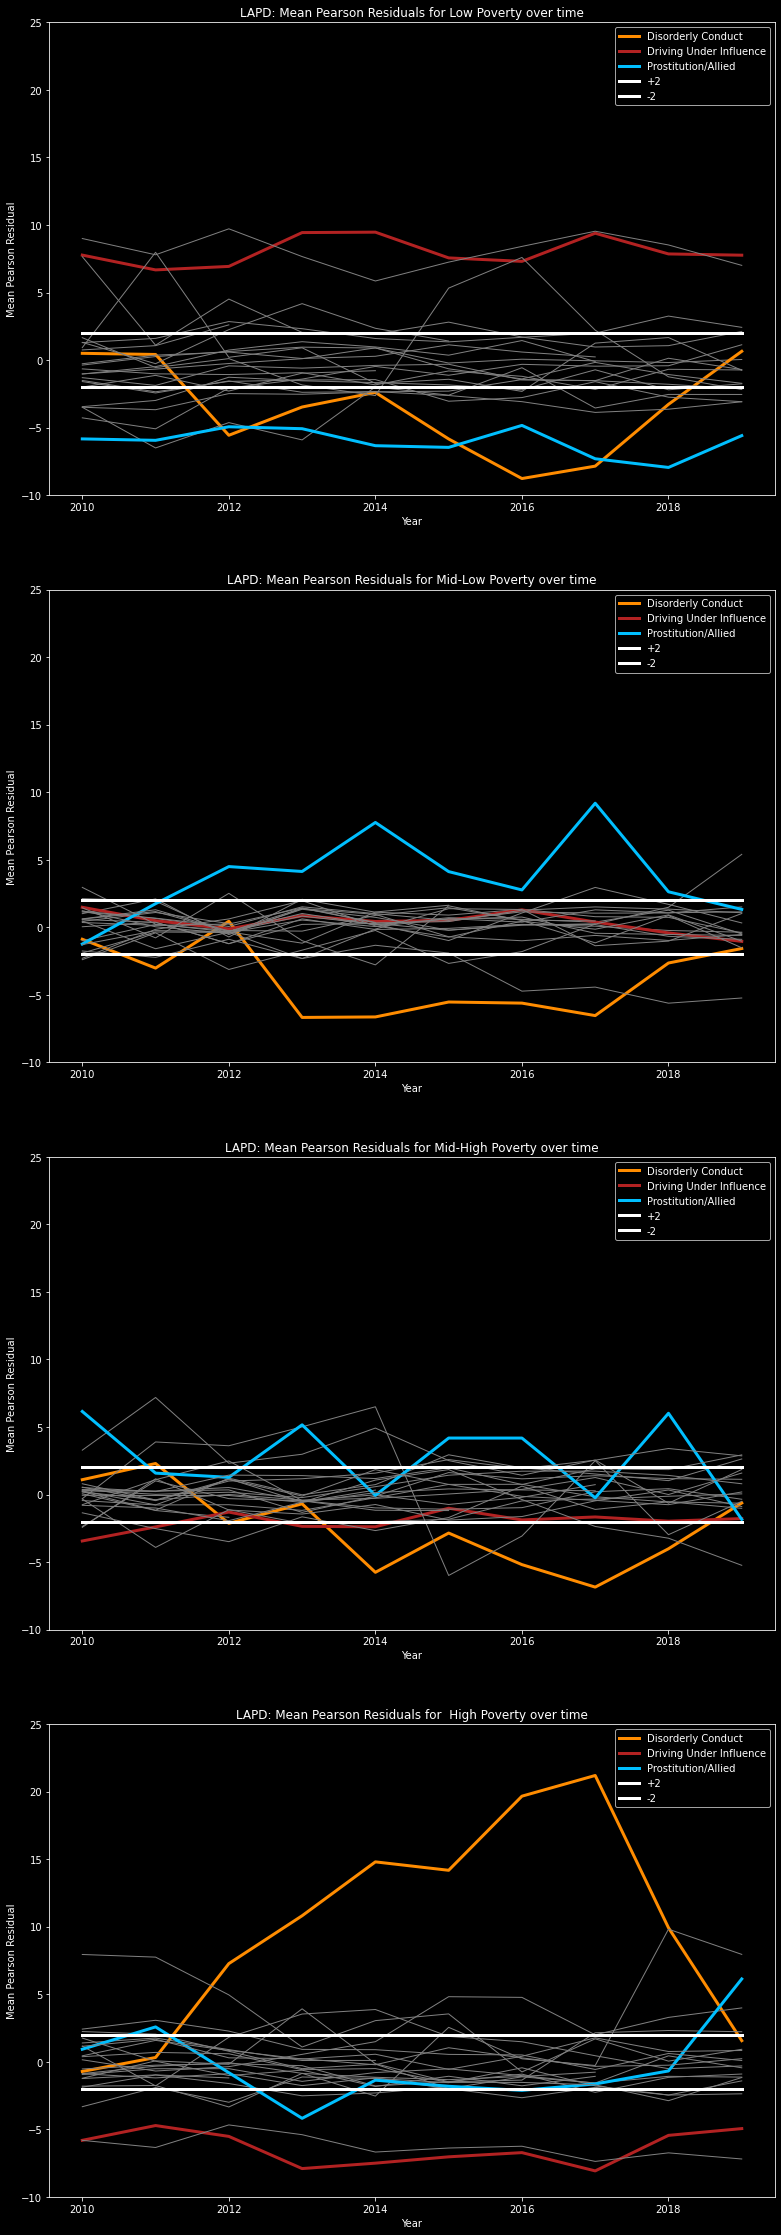

In [85]:
notable_cols =  ['Driving Under Influence','Prostitution/Allied',
             'Disorderly Conduct',
                '+2', '-2'] # By inspection
colors = ['darkorange','firebrick','deepskyblue','white','white']
poverties = df_poverty.columns.tolist()[1:-1]
fig, axis = plt.subplots(nrows = len(poverties), ncols = 1, figsize = (13,len(poverties) *10))
for i, poverty in enumerate(poverties):
    df_p_res = get_res_poverty(poverty, df_poverty)
    df_p_res['+2'] = 2
    df_p_res['-2'] = -2
    color_num = 0
    for col in df_p_res.columns:
        if col in notable_cols:
            axis[i].plot(df_p_res.index,df_p_res[col],linewidth = '3', color = colors[color_num], label = col)
            #axis[i].text(df_p_res.index[-1] + .5,df_p_res[col].tolist()[-1],col, fontsize = 14)
            color_num += 1 
        else: 
            axis[i].plot(df_p_res.index,df_p_res[col],color = 'grey',linewidth = '1')
    text = axis[i].set(ylim = (-10.00, 25.00),
        xlabel = 'Year',
        ylabel ='Mean Pearson Residual',
        title = '%s: Mean Pearson Residuals for %s over time'%(department,poverty))
    axis[i].legend()

# NYPD
Here we include visualizations of New York police data so that they can be visible without being required to run the notebook. The code above will still produce graphs for NYPD, so long as the variable department is set equal to 'NYPD'.

## Read Clean/Data

In [9]:
department = 'NYPD'
df_race, df_income, df_poverty = read_data_clean(department = department)

## Pearson's Chi-Square Test

In [35]:
pearson_chi2_year(df_race,year = 2019)

Year 2019: P-value= 0.000000, Test Statistic= 243.037624, dof = 44.000000, critical value = 60.480887
Reject H0 (DEPENDENT)


In [36]:
department

'NYPD'

## Mean of Pearson Residuals

### Race

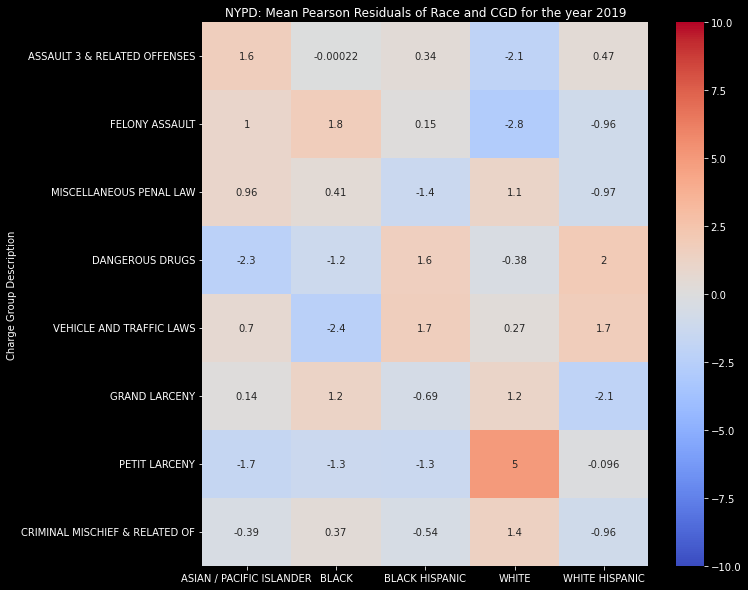

In [89]:
fig, ax = plt.subplots(figsize = (10,10))
year = 2019
text = sns.heatmap(mean_pearson_residuals_year(year, df_race).dropna(how = 'all'), annot=True, vmin = -10, vmax = 10,cmap = 'coolwarm' , ax = ax) 
text = ax.set(title = '%s: Mean Pearson Residuals of Race and CGD for the year %s'%(department,year))

In this heatmap there are fewer numbers of CGD becuase racial group ASIAN/PACIFIC ISLANDER was often not represented in the contigency table enough for that CGD to stay within the contingency table. Since we are dropping CGD that do not have more than 10 occurences after the sampling, this meant that the racial group ASIAN/PACIFIC ISLANDER forced us to drop several CGD. Regardless, there are still several combinations of CGD and race that are major contributors to dependecy. Arrests for White individuals and petit larceny is the most visible contributor, but there are also several comibinations that occur less frequently than would be expected, like White Hispanic and Grand Larceny.

### Income

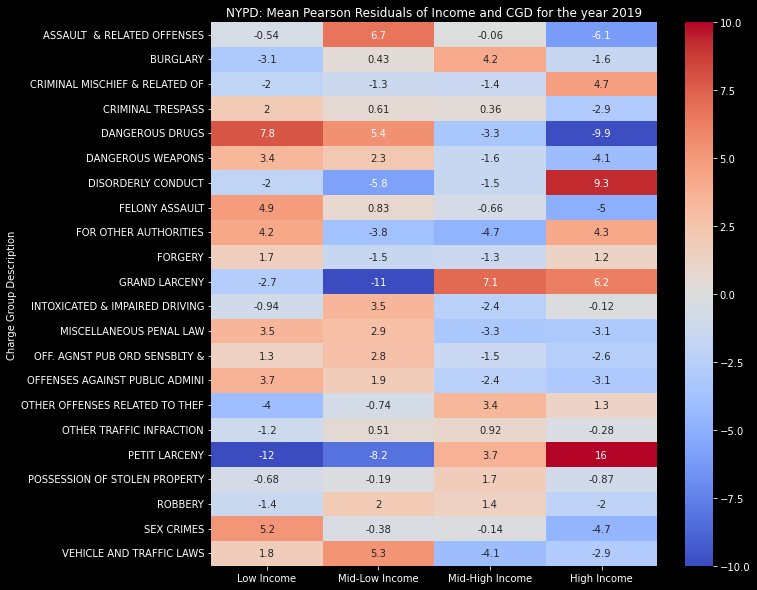

In [90]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_income[df_income['Year'] == 2019].drop('Year', axis = 1).set_index('Charge Group Description'),
           annot = True, vmin = -10, vmax = 10, cmap = 'coolwarm')
text = ax.set(title = '%s: Mean Pearson Residuals of Income and CGD for the year %s'%(department,year))

For arrests taken place in High-Income areas, the CGD's that occur more frequently than expected are Petit Larceny and Disorderly Conduct, and the CGD's that occur less fequently than expected are dangerous drugs and assualt & related offenses.

### Poverty

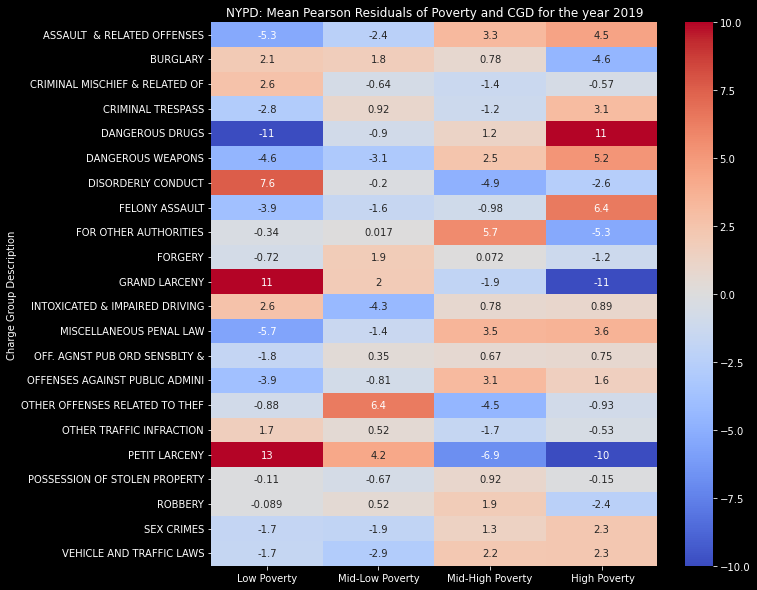

In [91]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_poverty[df_poverty['Year'] == 2019].drop('Year', axis = 1).set_index('Charge Group Description'),
           annot = True, vmin = -10, vmax = 10, cmap = 'coolwarm')
text = ax.set(title = '%s: Mean Pearson Residuals of Poverty and CGD for the year %s'%(department,year))

## Vizualizing the Change of Pearson Residuals over Time

In [11]:
# Mean Pearson Residuals of every year in the dataset
years = np.sort(np.array(df_race['Year'].unique())) # what years are present in our dataset
residuals_year = []
for year in years:
    residuals_year.append(mean_pearson_residuals_year(year, df_race))

### Race

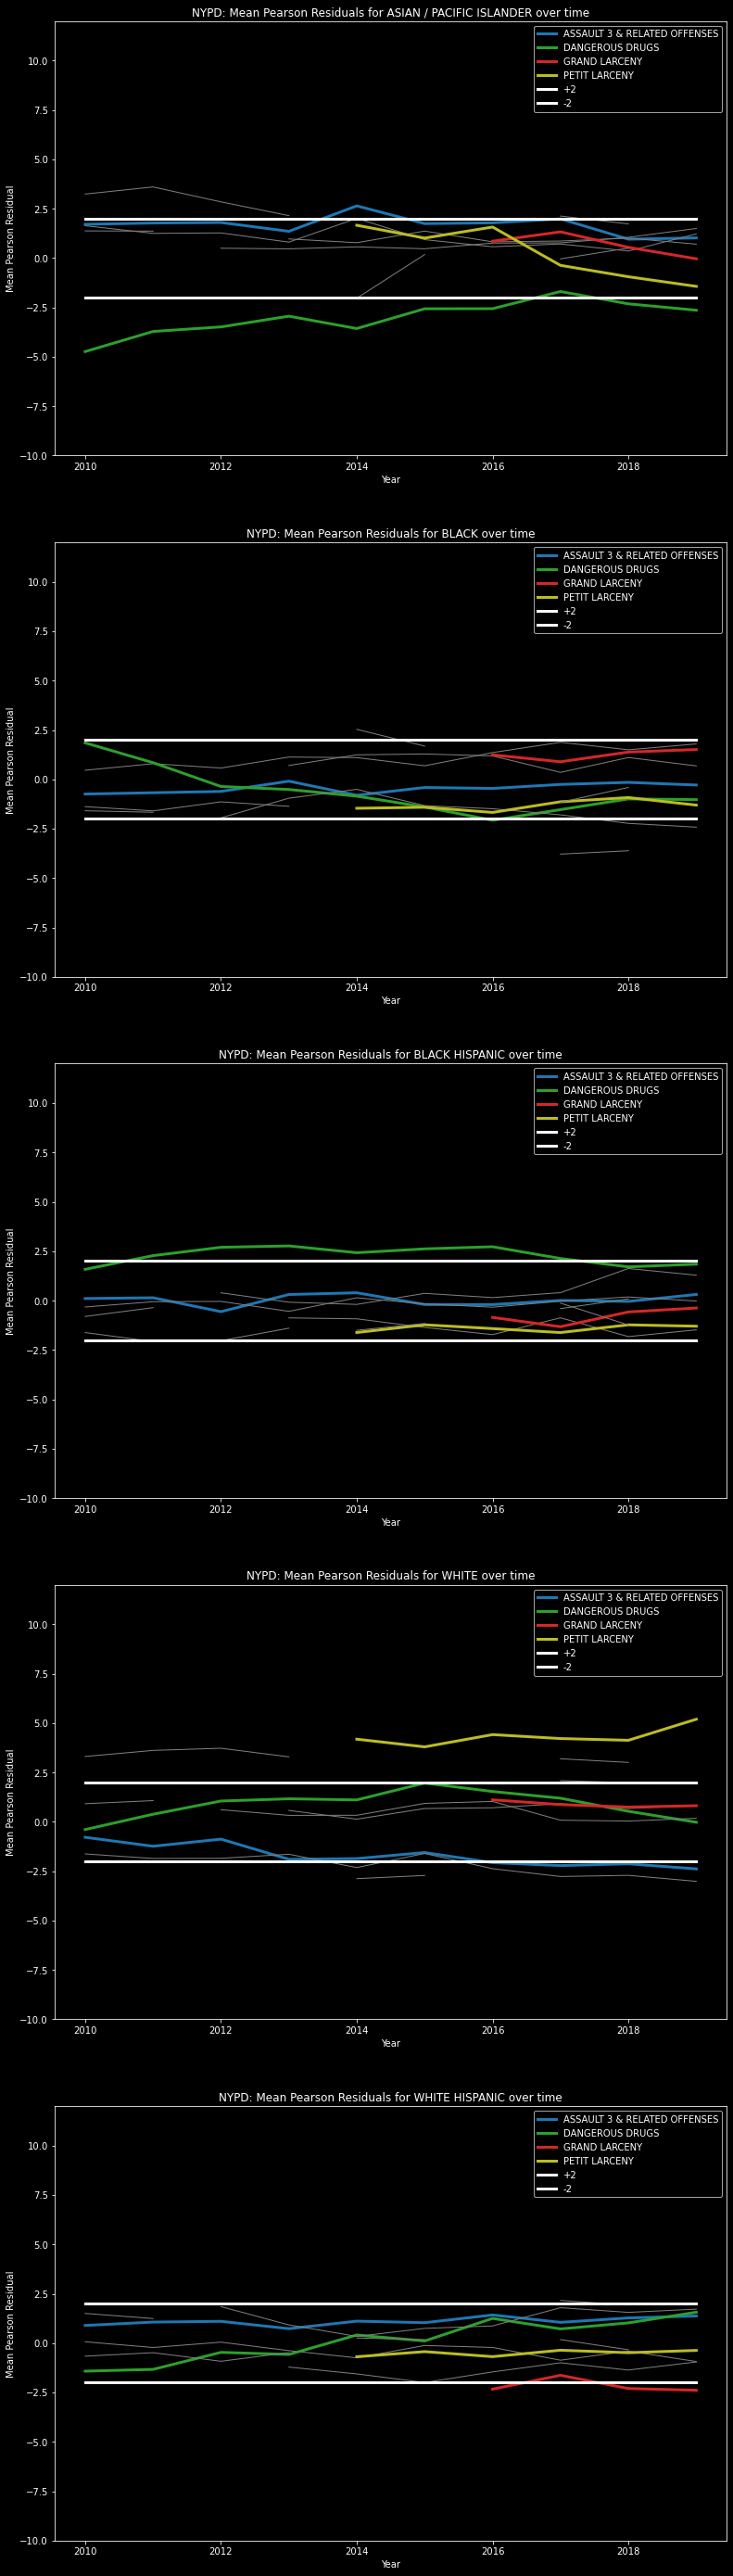

In [20]:
## Highlight CGD of particluar note in NYPD
## Matplotlib of Mean Pearson Residuals change over time for every Race
notable_cols = ['DANGEROUS DRUGS',
                'PETIT LARCENY',
                'ASSAULT 3 & RELATED OFFENSES',
                'GRAND LARCENY',
                '+2',
                '-2'] # by inspection

colors = ['tab:blue','tab:green','tab:red','tab:olive','white','white']
races = residuals_year[0].columns
fig, axis = plt.subplots(nrows = len(races), ncols = 1, figsize = (13,len(races) * 10))
for i, race in enumerate(races):
    df_p_res = get_res_race(race)
    df_p_res['+2'] = 2
    df_p_res['-2'] = -2
    color_num = 0
    for col in df_p_res.columns:
        if col in notable_cols:  
            axis[i].plot(df_p_res.index,df_p_res[col], linewidth = '3', color = colors[color_num], label = col)
            #axis[i].text(df_p_res.index[-1] + .5,df_p_res[col].tolist()[-1],col, fontsize = 14)
            color_num += 1
        else:
            axis[i].plot(df_p_res.index,df_p_res[col], color = 'grey', linewidth = '1')
    text = axis[i].set(ylim = (-10.00, 12.00),
                xlabel = 'Year',
                ylabel ='Mean Pearson Residual',
                title = '%s: Mean Pearson Residuals for %s over time'%(department,race))
    axis[i].legend()

Some of these CGD do not have mean pearson residuals for certain years. This is because when we calculate our residuals from the contingency tables we drop CGD that less than 10 occurrences for a single social group. For example, there is no pearson residuals for petit larceny in 2012 becuase there was a social group that didn't have more than 10 occrences after sampling. 

### Income

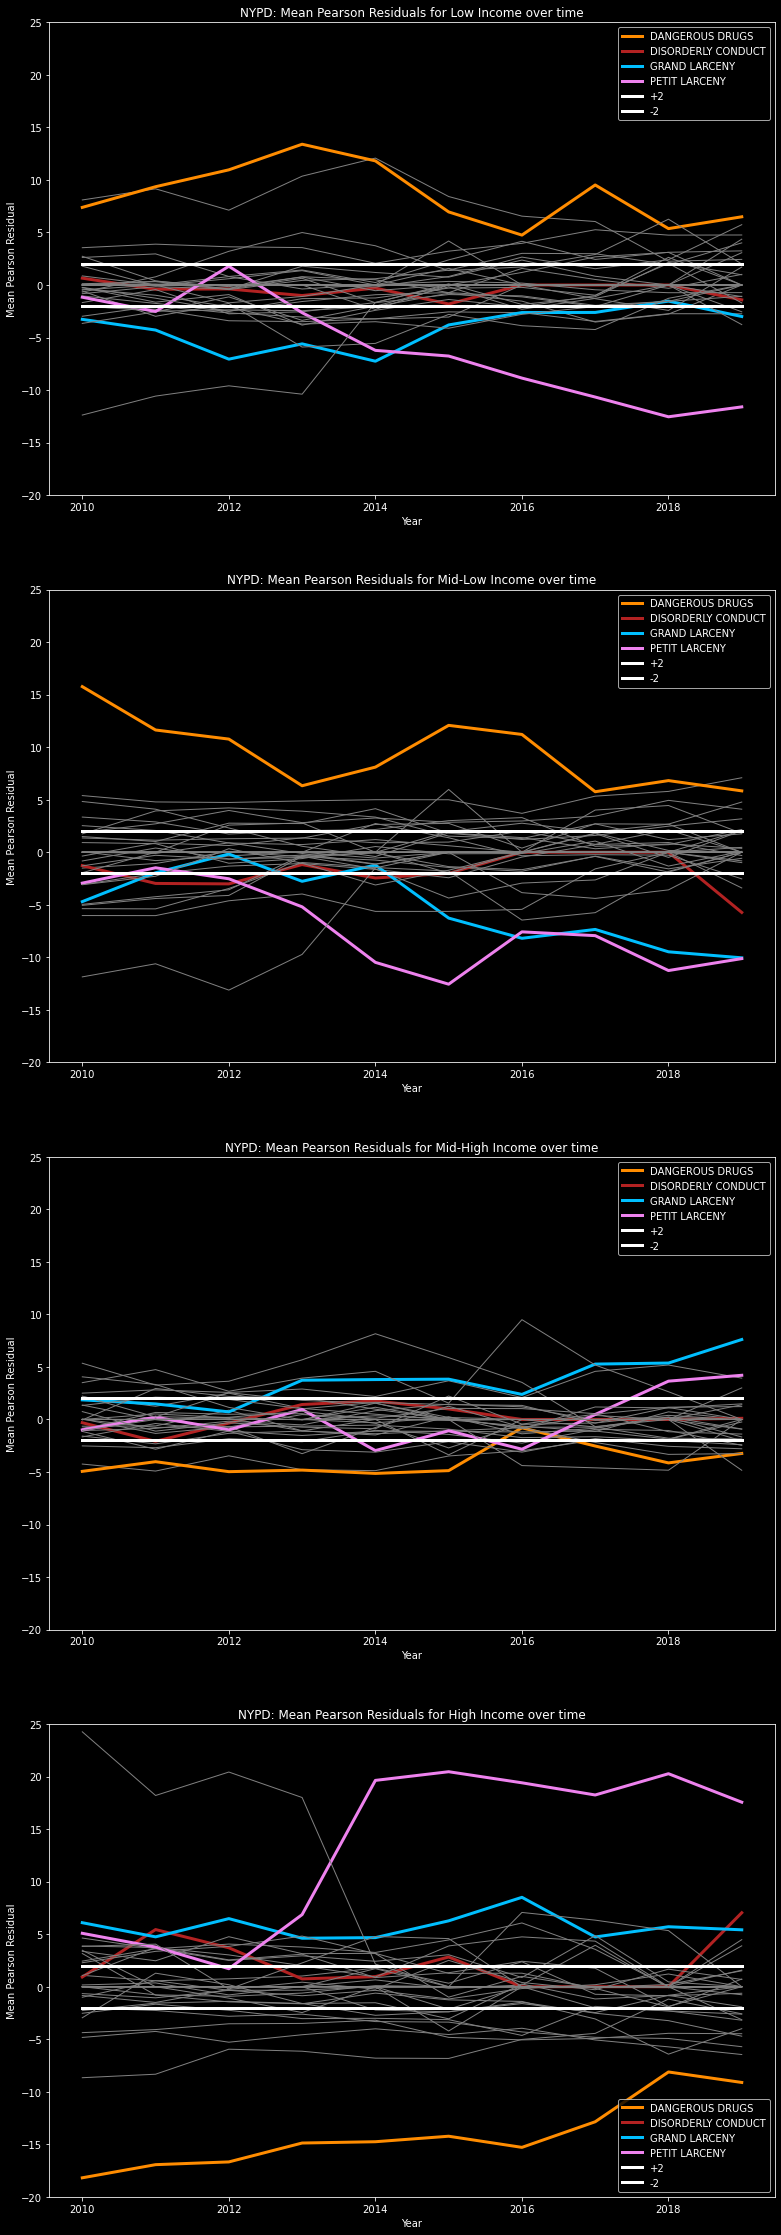

In [21]:
notable_cols =  ['PETIT LARCENY', 'DISORDERLY CONDUCT', 'DANGEROUS DRUGS','GRAND LARCENY', '+2','-2'] # By inspection
colors = ['darkorange','firebrick','deepskyblue','violet','white','white']

incomes = df_income.columns.tolist()[1:-1]
fig, axis = plt.subplots(nrows = len(incomes), ncols = 1, figsize = (13,len(incomes) *10))
for i, income in enumerate(incomes):
    df_p_res = get_res_income(income, df_income)
    df_p_res['+2'] = 2
    df_p_res['-2'] = -2
    df_p_res.fillna(0, inplace = True)
    color_num = 0
    for col in df_p_res.columns:
        if col in notable_cols:
            #print(color_num)
            axis[i].plot(df_p_res.index,df_p_res[col],linewidth = '3', color = colors[color_num], label = col)
            #axis[i].text(df_p_res.index[-1] + .5,df_p_res[col].tolist()[-1],col, fontsize = 14)
            color_num +=1 
        else:
            axis[i].plot(df_p_res.index,df_p_res[col],color = 'grey',linewidth = '1')
    text = axis[i].set(ylim = (-20.00, 25.00),
        xlabel = 'Year',
        ylabel ='Mean Pearson Residual',
        title = '%s: Mean Pearson Residuals for %s over time'%(department,income))
    axis[i].legend()

### Poverty

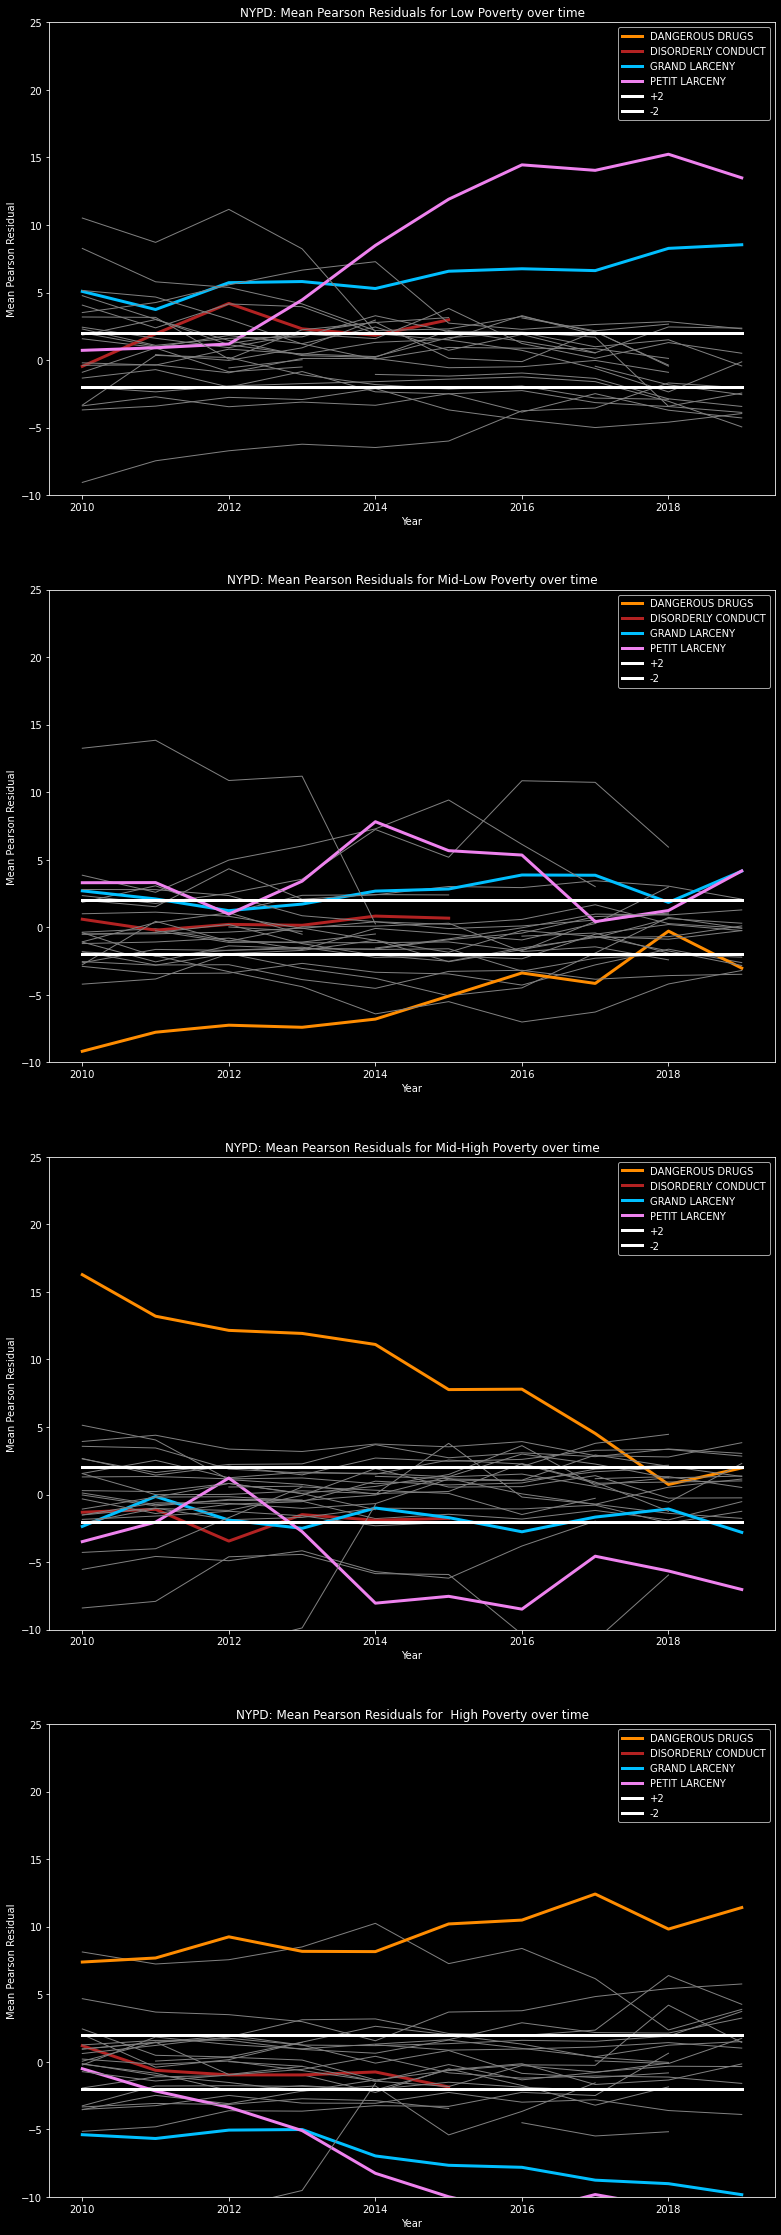

In [25]:
notable_cols =  ['PETIT LARCENY', 'DISORDERLY CONDUCT', 'DANGEROUS DRUGS','GRAND LARCENY', '+2','-2'] # By inspection
colors = ['darkorange','firebrick','deepskyblue','violet','white','white']
poverties = df_poverty.columns.tolist()[1:-1]
fig, axis = plt.subplots(nrows = len(poverties), ncols = 1, figsize = (13,len(poverties) *10))
for i, poverty in enumerate(poverties):
    df_p_res = get_res_poverty(poverty, df_poverty)
    df_p_res['+2'] = 2
    df_p_res['-2'] = -2
    color_num = 0
    for col in df_p_res.columns:
        if col in notable_cols:
            axis[i].plot(df_p_res.index,df_p_res[col],linewidth = '3', color = colors[color_num], label = col)
            #axis[i].text(df_p_res.index[-1] + .5,df_p_res[col].tolist()[-1],col, fontsize = 14)
            color_num += 1 
        else: 
            axis[i].plot(df_p_res.index,df_p_res[col],color = 'grey',linewidth = '1')
    text = axis[i].set(ylim = (-10.00, 25.00),
        xlabel = 'Year',
        ylabel ='Mean Pearson Residual',
        title = '%s: Mean Pearson Residuals for %s over time'%(department,poverty))
    axis[i].legend()

## Comparing and Contrasting LAPD and NYPD

In [27]:
df_race_lapd, df_income_lapd, df_poverty_lapd = read_data_clean('LAPD')
df_race_nypd, df_income_nypd, df_poverty_nypd = read_data_clean('NYPD')

### Race

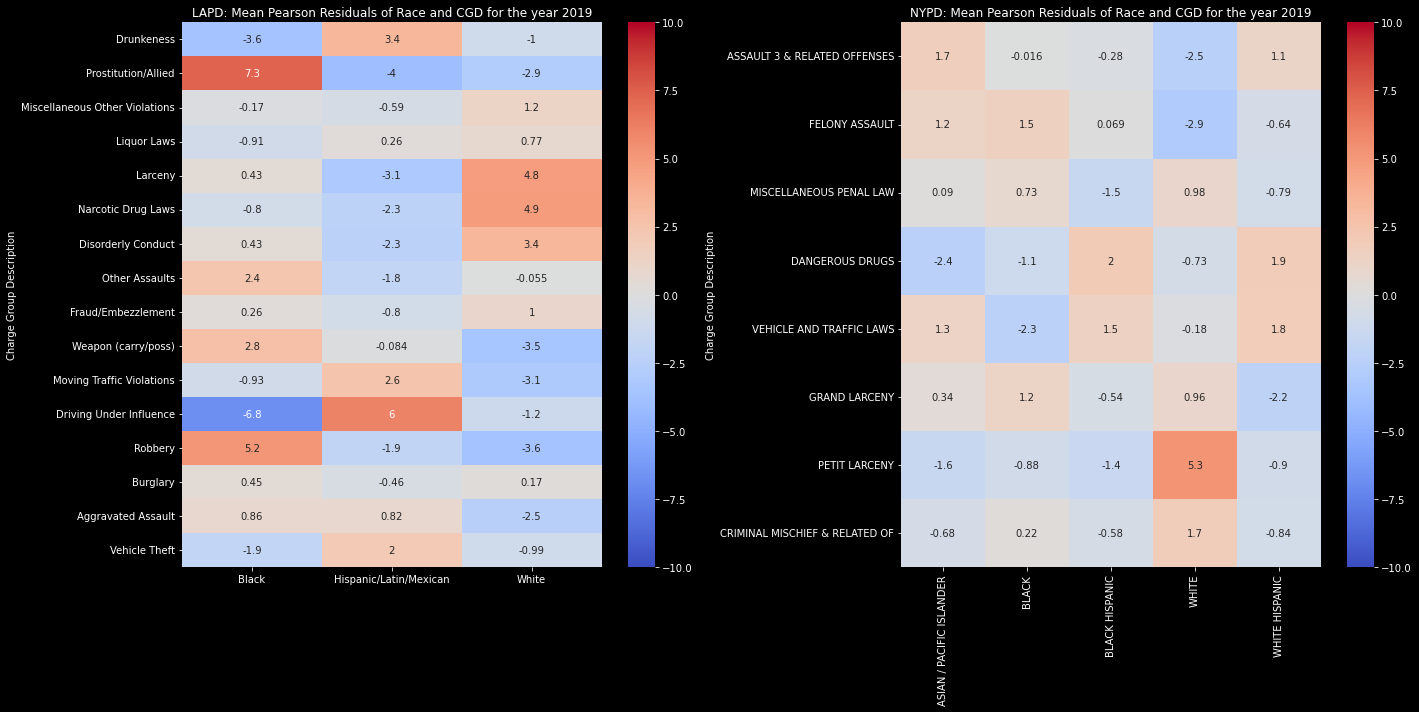

In [28]:
fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
year = 2019
text = sns.heatmap(mean_pearson_residuals_year(year, df_race_lapd).dropna(how = 'all'), annot=True, vmin = -10, vmax = 10,cmap = 'coolwarm' , ax = ax1) 
text = ax1.set(title = '%s: Mean Pearson Residuals of Race and CGD for the year %s'%('LAPD',year))

text = sns.heatmap(mean_pearson_residuals_year(year, df_race_nypd).dropna(how = 'all'), annot=True, vmin = -10, vmax = 10,cmap = 'coolwarm' , ax = ax2) 
text = ax2.set(title = '%s: Mean Pearson Residuals of Race and CGD for the year %s'%('NYPD',year))
fig.tight_layout()

There are some interesting results to be drawn from analyzing the two police departments side by side, but before we make any conclusion we must address the different racial categories. Firstly, we do not know whether racial group is self reported or if the arresting officers makes assumptions. Secondlly, while the LAPD categorizes arrested individuals as Black, Hispanic/Latin/Mexican, and White, the NYPD categorizes arrests according to ASIAN/PACIFIC ISLANDER, BLACK,  WHITE, BLACK HISPANIC, and WHITE HISPANIC. To compare racial groups across departments our categories would have to be standardized so that a racial group in NYPD dataset would be mapped to the same racial group in the LAPD dataset. If assume that the police departments are using self reported racial data, then LAPD White and Black could be compared to NYPD WHITE and BLACK. As for LAPD Hispanic/Latin/Mexican, we could consider grouping NYPD WHITE HIPANIC and BLACK HIPANIC togther, but this isn't an assumption that holds under closer examination. For example, we can consider an individual X who is 25% hispanic and 75% white to see how this falls apart in the case of the NYPD and LAPD. In the NYPD dataset, individual X is WHITE HISPANIC and in the LAPD dataset individual X would be majority White. If we grouped NYPD's WHITE HISPANIC and BLACK HISPANIC into 'HISPANIC', then individual X would be considered HISPANIC in NYPD and White in LAPD, which isn't a standard definition of racial groups. Therefore we avoid drawing comparisions between departments across race.

### Income

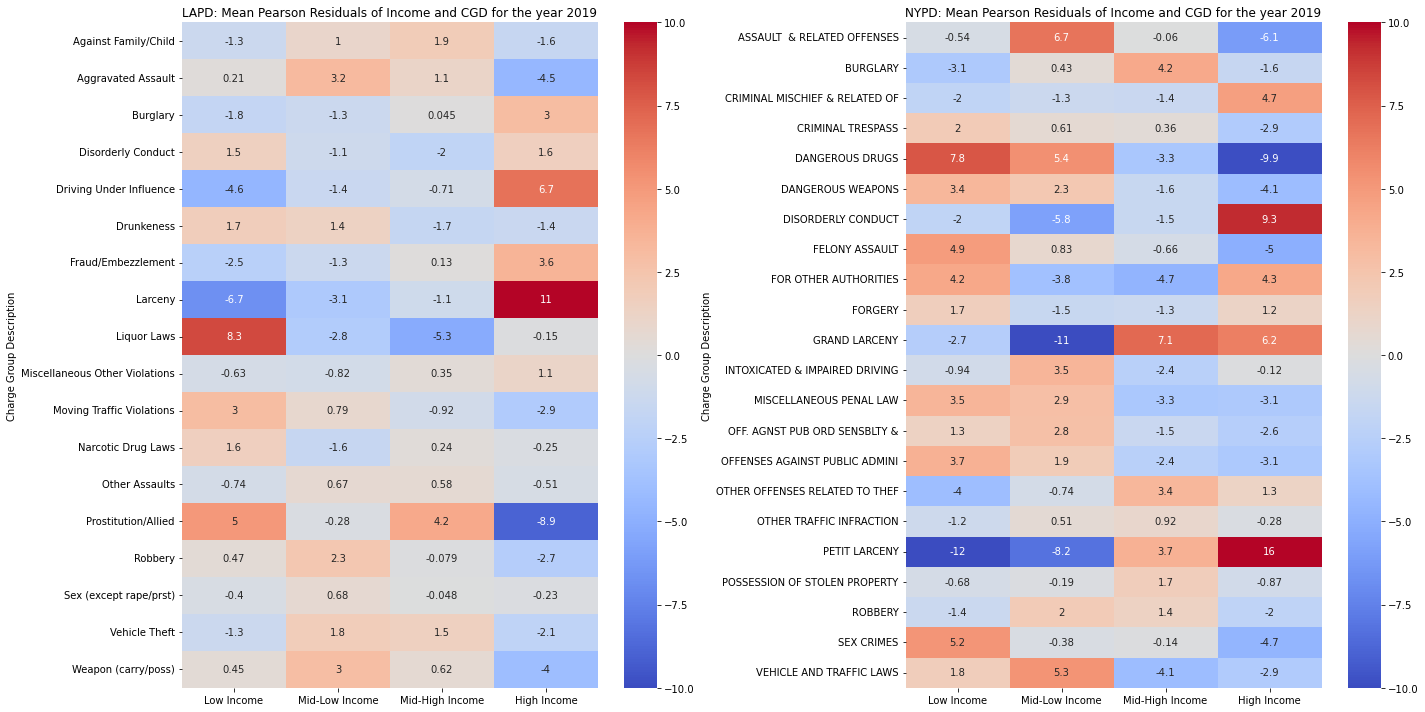

In [51]:
plt.style.use('seaborn-colorblind')
year = 2019
fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2,figsize = (20,10))

sns.heatmap(df_income_lapd[df_income_lapd['Year'] == year].drop('Year', axis = 1).set_index('Charge Group Description'),
           annot = True, vmin = -10, vmax = 10, cmap = 'coolwarm', ax = ax1)
text = ax1.set(title = '%s: Mean Pearson Residuals of Income and CGD for the year %s'%('LAPD',year))
sns.heatmap(df_income_nypd[df_income_nypd['Year'] == year].drop('Year', axis = 1).set_index('Charge Group Description'),
           annot = True, vmin = -10, vmax = 10, cmap = 'coolwarm', ax = ax2)
text = ax2.set(title = '%s: Mean Pearson Residuals of Income and CGD for the year %s'%('NYPD',year))
fig.tight_layout()

Since income and poverty groups are calculated using percentiles, it is more appropriate to make comparisions between departments. That being said, there are several factors that influence arrests that these heatmaps don't demonstrate. The FBI's Uniform Crime Reporting comments on making comparisons (https://ucr.fbi.gov/ucr-statistics-their-proper-use) and list factors such as climtate, modes of transportation and highway systems, crime reporting practices of the citizenry, and cultural factors and educational, recreational, and religious characteristics.

### Poverty

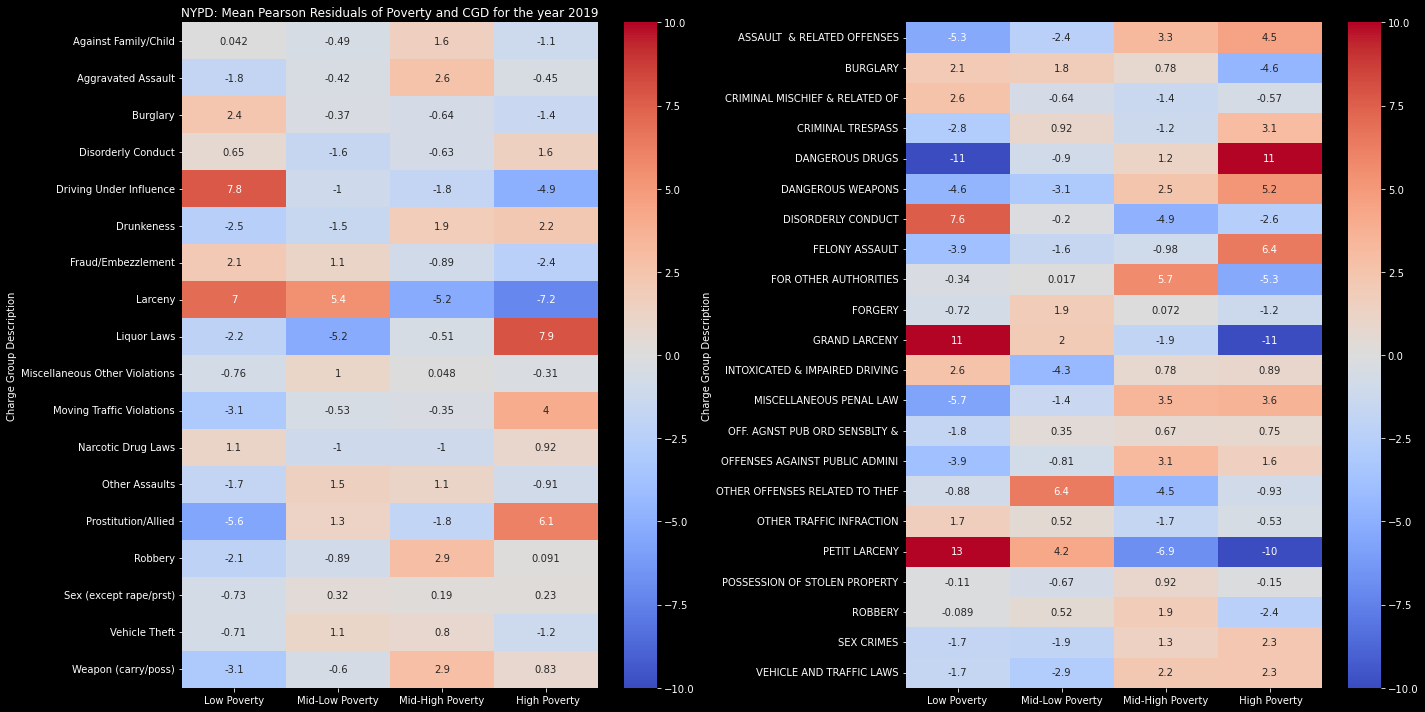

In [11]:
fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2,figsize = (20,10))
sns.heatmap(df_poverty_lapd[df_poverty_lapd['Year'] == 2019].drop('Year', axis = 1).set_index('Charge Group Description'),
           annot = True, vmin = -10, vmax = 10, cmap = 'coolwarm', ax = ax1)
text = ax1.set(title = '%s: Mean Pearson Residuals of Poverty and CGD for the year %s'%('LAPD',year))
sns.heatmap(df_poverty_nypd[df_poverty_nypd['Year'] == 2019].drop('Year', axis = 1).set_index('Charge Group Description'),
           annot = True, vmin = -10, vmax = 10, cmap = 'coolwarm', ax = ax2)
text = ax1.set(title = '%s: Mean Pearson Residuals of Poverty and CGD for the year %s'%('NYPD',year))
fig.tight_layout()

## Extra Visuals:

### Mean Pearson Residuals for Every Year

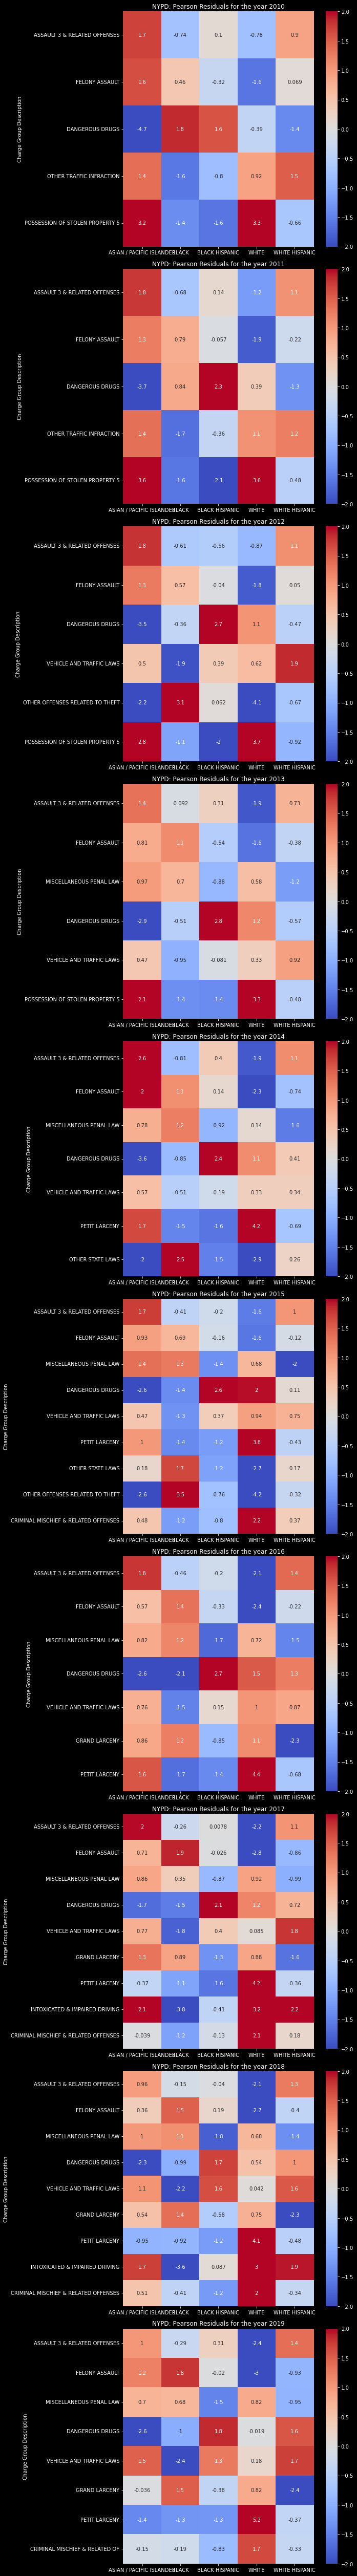

In [34]:
years = np.sort(np.array(df_race['Year'].unique())) # what years are present in our dataset
fig, axis  = plt.subplots(nrows = len(years), ncols = 1, figsize = (10,70)) 
for i,res in enumerate(residuals_year):
    text = sns.heatmap(res.dropna(how = 'all'), annot=True, vmin = -2, vmax = 2 ,cmap = 'coolwarm' , ax = axis[i]) #, mask = mask)
    text = axis[i].set(title = '%s: Mean Pearson Residuals for the year %d'%(department, years[i])) 
fig.tight_layout()

### Plotly
These do not will not show up without running, but they do provide cleaner vizualitions. Run the code for Import Packages, Define Functions, Read/Clean Data, and the cell of code directly beneath Vizualizing the Change of Pearson Residuals over Time.

In [31]:
## Plotly of Mean Pearson Residuals change over time for all races
for race in residuals_year[0].columns:
    df_res = get_res_race(race).dropna(how = 'all', axis = 1)
    df_res['+2'] = 2
    df_res['-2'] = -2
    fig = px.line(data_frame = df_res, x = df_res.index, y = df_res.columns,range_y = (-12,12), template = 'plotly_dark',title = '%s Mean Pearson Residuals for %s'%(department,race))
    fig.show()

In [20]:
incomes = ['Low Income','Mid-Low Income','Mid-High Income','High Income']
for income in incomes:
    df_res_income = get_res_income(income, df_income_lapd)
    df_res_income['+2'] = 2
    df_res_income['-2'] = -2
    fig = px.line(df_res_income, x = df_res_income.index, y = df_res_income.columns,
                  range_y = (-15,25),template ='simple_white',title = 'Pearson Residuals for %s'%income)
    fig.show()

In [32]:
poverty = ['Low Poverty','Mid-Low Poverty','Mid-High Poverty','High Poverty']
for poverty in poverties:
    df_res_poverty = get_res_income(poverty, df_poverty_lapd)
    df_res_poverty['+2'] = 2
    df_res_poverty['-2'] = -2
    fig = px.line(df_res_poverty, x = df_res_poverty.index, y = df_res_poverty.columns,
                  range_y = (-15,25),template ='simple_white',title = 'Pearson Residuals for %s'%poverty)
    fig.show()